# Image segmentation on the CityScape dataset  
**This notebook is meant to test the code prior to launch training and deployment in the cloud.**

## Import librairies and set-up parameters

In [1]:

import sys
sys.path.append('./src')

import importlib
import config
importlib.reload(config)

import numpy as np

import PIL
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import save_img

from labels import labels

import utils
importlib.reload(utils)
from utils import check_paths
from utils import get_paths
from utils import resize
from utils import remove
from utils import convert_id2cat

from albumentations import (Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,Rotate)

In [2]:
preprocess = False

id2cat = {label.id: label.categoryId for label in labels}

augmentation = config.augmentation
true_one_hot = config.true_one_hot

## Compute the paths to images and format the images

In [3]:
if preprocess == True:

    # Define source and target directories
    src_dir = r"D:\Data\Google Drive\Openclassrooms\P8\data\full\P8_Cityscapes_leftImg8bit_trainvaltest"
    target_dir = r"D:\Data\Google Drive\Openclassrooms\P8\data\full\P8_Cityscapes_gtFine_trainvaltest"

    # Clean files from previous preprocessing
    src_paths, target_paths = get_paths(src_dir, target_dir, '*', '*', verbose=False)

    suffix = '_reduced.png'
    remove(src_paths['train'], target_paths['train'],  suffix)
    remove(src_paths['val'], target_paths['val'], suffix)
    remove(src_paths['test'], target_paths['test'],  suffix)

    suffix = '_cats.png'
    remove(src_paths['train'], target_paths['train'],  suffix)
    remove(src_paths['val'], target_paths['val'], suffix)
    remove(src_paths['test'], target_paths['test'],  suffix)

    # Retrieve the list of original source and target images
    src_paths, target_paths = get_paths(src_dir, target_dir, '*.png', '*_gtFine_labelIds.png')

    # Resize the images
    resize(src_paths['train'], target_paths['train'], 384, 576)
    resize(src_paths['val'], target_paths['val'], 384, 576)
    resize(src_paths['test'], target_paths['test'], 384, 576)

    # Retrieve the list of reduced source and target images
    src_paths, target_paths = get_paths(src_dir, target_dir, '*_reduced.png', '*_reduced.png')

    # Convert the coding of target images pixels from ids to categories
    convert_id2cat(target_paths['train'], id2cat)
    convert_id2cat(target_paths['val'], id2cat)
    convert_id2cat(target_paths['test'], id2cat)

    # Retrieve the list of reduced source and converted target images
    src_paths, target_paths = get_paths(src_dir, target_dir, '*_reduced.png', '*_reduced_cats.png')


## Copy the reformated images to dedicated folders

In [4]:
if preprocess == True:

    # Define source and target directories
    src_dir = r"D:\Data\Google Drive\Openclassrooms\P8\data\full\P8_Cityscapes_leftImg8bit_trainvaltest"
    target_dir = r"D:\Data\Google Drive\Openclassrooms\P8\data\full\P8_Cityscapes_gtFine_trainvaltest"
    src_dir_copy = r"D:\Data\Google Drive\Openclassrooms\P8\data\full\src\P8_Cityscapes_leftImg8bit_trainvaltest"
    target_dir_copy = r"D:\Data\Google Drive\Openclassrooms\P8\data\full\target\P8_Cityscapes_gtFine_trainvaltest"

    src_paths, target_paths = get_paths(src_dir, target_dir, '*_reduced.png', '*_reduced_cats.png')

    types = ['train', 'val', 'test']

    orig = 'src'

    if orig == 'src':
        dir = src_dir
        dir_copy = src_dir_copy
        paths = src_paths
        common_path = os.path.commonpath([dir, dir_copy])
        middle_path = dir_copy[len(common_path)+1:]
        grayscale = False

    if orig == 'target':
        dir = target_dir
        dir_copy = target_dir_copy
        paths = target_paths
        common_path = os.path.commonpath([dir, dir_copy])
        middle_path = dir_copy[len(common_path)+1:]
        grayscale = True

    for type in types:
        i=-1
        for path in paths[type]:
            path_copy = os.path.join(common_path, middle_path, path[len(common_path)+1:])
            try:
                os.makedirs(os.path.dirname(path_copy))
            except FileExistsError:
                pass            
            im = load_img(path)
            save_img(path_copy, im, scale=False)
            if i == 1:
                break
        if i == 1:
            break    

### If all the above preprocessing has already been done, directly compute the paths to the preprocessed images

In [5]:
if preprocess == False:
    src_dir= r"D:\Data\Google Drive\Openclassrooms\P8\data\full\src\P8_Cityscapes_leftImg8bit_trainvaltest"
    target_dir = r"D:\Data\Google Drive\Openclassrooms\P8\data\full\target\P8_Cityscapes_gtFine_trainvaltest"
    src_paths, target_paths = get_paths(src_dir, target_dir, '*_reduced.png', '*_reduced_cats.png')


Number of train files:
    in the source directory: 2975
    in the target directory: 2975

Number of val files:
    in the source directory: 500
    in the target directory: 500

Number of test files:
    in the source directory: 1525
    in the target directory: 1525


## What does one input image and corresponding segmentation mask look like?

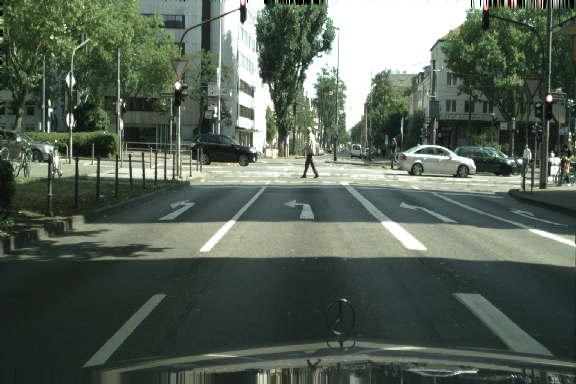

Image shape:  (384, 576, 3)


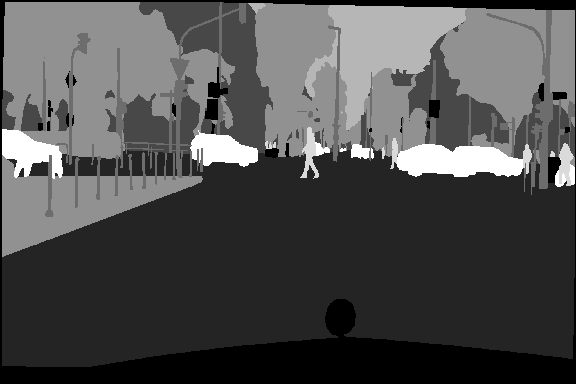

Target shape:  (384, 576)


In [6]:
from IPython.display import Image, display
import PIL
from PIL import ImageOps

# Display input image 
image_n = 15
type = 'val'
img = load_img(src_paths[type][image_n])
display(img)
print(f"Image shape: ", np.array(img).shape)
# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_paths[type][image_n], color_mode='grayscale'))
display(img)
print(f"Target shape: ", np.array(img).shape)

## Import `Sequence` class and load & vectorize batches of data

In [7]:
import generate
importlib.reload(generate)
from generate import CityScapes
importlib.reload(config)
batch_size = config.batch_size
model_input_size = config.model_input_size
model_output_size = config.model_output_size
true_one_hot = config.true_one_hot

# Instantiate data Sequences for each split
train_gen = CityScapes(batch_size, model_input_size, model_output_size,
                       src_paths['train'], target_paths['train'],
                       augmentation=augmentation,
                       true_one_hot=true_one_hot, 
                       model_type=config.model_type,)
val_gen = CityScapes(batch_size, model_input_size, model_output_size,
                     src_paths['val'], target_paths['val'], 
                     augmentation=False,
                     true_one_hot=true_one_hot,
                     model_type=config.model_type)
demo_gen = CityScapes(batch_size, model_input_size, model_output_size,
                      src_paths['train'], target_paths['train'],
                      augmentation=augmentation,
                      true_one_hot=true_one_hot, 
                      model_type=config.model_type, 
                      demoing=True)

## What does an augmented batch of data look like?

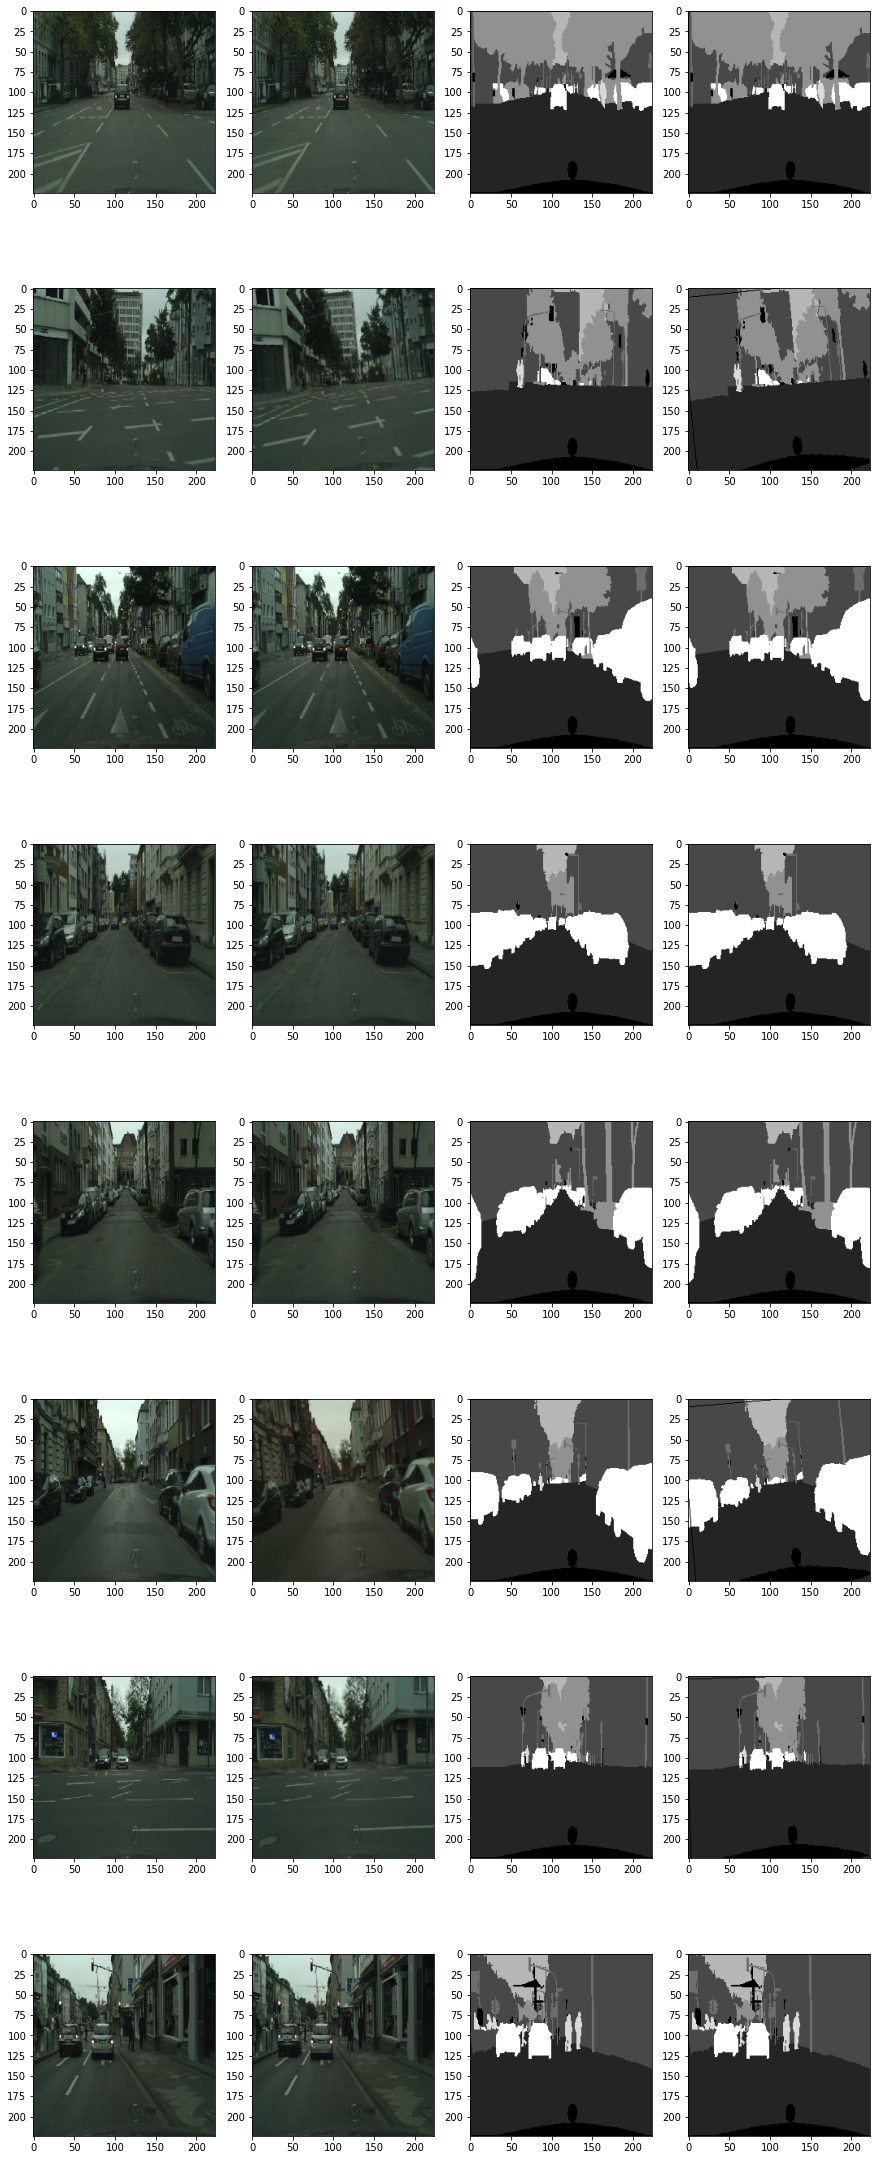

In [8]:
from IPython.display import Image, display
import PIL
from PIL import ImageOps

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline

batch_size = 8
batch_n = 15
is_src = 0
is_target = 1
is_orig = 0
is_aug = 1

# display images
fig, ax = plt.subplots(batch_size,4, figsize=(15,5*batch_size))
demo = demo_gen[batch_n]
for img_n in range(batch_size):
 
    # Get image arrays
    array_src_orig = demo[is_src][is_orig][img_n] # batch_n, src/target, orig/aug, img_n
    array_src_aug = demo[is_src][is_aug][img_n] 
    array_target_orig = demo[is_target][is_orig][img_n] 
    array_target_orig = np.squeeze(array_target_orig, axis=-1)
    array_target_aug = demo[is_target][is_aug][img_n] 
    array_target_aug = np.squeeze(array_target_aug, axis=-1)

    # Transform into images
    img_src_orig = PIL.Image.fromarray(array_src_orig)
    img_src_aug = PIL.Image.fromarray(array_src_aug)

    img_target_orig = PIL.Image.fromarray(array_target_orig, mode='L')
    img_target_orig = PIL.ImageOps.autocontrast(img_target_orig)

    img_target_aug = PIL.Image.fromarray(array_target_aug, mode='L')
    img_target_aug = PIL.ImageOps.autocontrast(img_target_aug)

    ax[img_n,0].imshow(img_src_orig);
    ax[img_n,1].imshow(img_src_aug);
    ax[img_n,2].imshow(img_target_orig,cmap='gray', vmin=0, vmax=255);
    ax[img_n,3].imshow(img_target_aug, cmap='gray', vmin=0, vmax=255);


## Train the model
### Get the model

In [9]:
from tensorflow.keras import layers
from tensorflow import keras

importlib.reload(config)

import models
importlib.reload(models)
from model import get_model

num_classes = config.num_classes
batch_size = config.batch_size


if config.model_type == 'unet_like':
    model = get_model(config.model_input_size, 
                      config.num_classes)


if config.model_type == 'vgg_unet':
    import unet
    importlib.reload(unet)
    from unet import vgg_unet
    model, base_model = vgg_unet(n_classes=num_classes,  
                                 input_height=config.model_input_size[0],
                                 input_width=config.model_input_size[1],
                                 encoder_level=3,
                                 trainable_base=config.trainable_base,)
    base_model.trainable == config.trainable_base
    fine_tuned_layers = ['block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool']


if config.model_type == 'resnet50_unet':
    import unet
    importlib.reload(unet)
    from unet import resnet50_unet
    model, base_model = resnet50_unet(n_classes=num_classes,
                          input_height=config.model_input_size[0],
                          input_width=config.model_input_size[1],
                          encoder_level=3,
                          trainable_base=config.trainable_base,)
    base_model.trainable == config.trainable_base


if config.model_type == 'resnet50_pspnet':
    import pspnet
    importlib.reload(pspnet)
    from pspnet import resnet50_pspnet
    model, base_model = resnet50_pspnet(n_classes=num_classes,  
                            input_height=config.model_input_size[0],
                            input_width=config.model_input_size[1],
                            trainable_base=config.trainable_base,)
    base_model.trainable == config.trainable_base


model.summary()

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Fit the model

In [10]:
# Parameters of the model for training.
importlib.reload(config)
importlib.reload(generate)
optimizer = config.optimizer
metrics = config.metrics
loss = config.loss
steps_per_epoch = config.steps_per_epoch
run_eagerly = False
    
model.compile(optimizer=optimizer,
              metrics=metrics,
              loss=loss,
              run_eagerly=run_eagerly,)

# Callbacks
from tensorflow import keras
callbacks = [keras.callbacks.ModelCheckpoint(r'./models/cityscapes_5', save_best_only=True, verbose = 1),]

# Train the model, doing validation at the end of each epoch.
epochs = 1 #config.epochs
steps_per_epoch = None
validation_steps = None
model.fit(train_gen, epochs=epochs, validation_data=val_gen, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, callbacks=callbacks)

371/371 [==============================] - ETA: 0s - loss: 0.9954 - sparse_categorical_accuracy: 0.7162 - dice_metric: 0.4269
Epoch 00001: val_loss improved from inf to 1.37691, saving model to ./models/cityscapes_5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/cityscapes_5\assets
371/371 [==============================] - 947s 3s/step - loss: 0.9954 - sparse_categorical_accuracy: 0.7162 - dice_metric: 0.4269 - val_loss: 1.3769 - val_sparse_categorical_accuracy: 0.5702 - val_dice_metric: 0.2088


### Fine tune the model

In [13]:
if config.model_type != 'unet_like':
    if config.model_type == 'vgg_unet':
        base_model.trainable = False
        for layer_name in fine_tuned_layers:
            layer = base_model.get_layer(layer_name)
            layer.trainable = True
    else:
        base_model.trainable = True

    model.compile(optimizer=config.optimizer,
                metrics=config.metrics,
                loss=config.loss,
                run_eagerly=config.run_eagerly)

In [ ]:
# Fine tune the model, doing validation at the end of each epoch.
if config.model_type != 'unet_like':
    epochs = 1
    steps_per_epoch = 5
    validation_steps = 5
    model.fit(train_gen,
                epochs=epochs , 
                validation_data=val_gen,
                steps_per_epoch = steps_per_epoch,
                validation_steps = None,
                callbacks=callbacks)

## Local deployment

In [ ]:
from azureml.core import Workspace, Environment
from azureml.core.webservice import LocalWebservice
from azureml.core.model import InferenceConfig, Model

# Connect to workspace
ws = Workspace.from_config()
print("\nWorkspace connected")

# Environment
env = Environment.from_conda_specification(name='P8-env',
                                           file_path='./env/env_azure_deploy.yml')
print("\nEnvironment configured")

# This is optional, if not provided Docker will choose a random unused port.
deployment_config = LocalWebservice.deploy_configuration(port=6789)
print("Deployment configured")

# Inference configuration
inference_config = InferenceConfig(source_directory='./src',
                                   entry_script='predict.py',
                                   environment=env)
print("\nInference configured") 

# Deploy
model = Model(ws, config.model_name)
local_service = Model.deploy(ws, "ws-seg-local", [model], inference_config, deployment_config)
print("Deployment configured")

local_service.wait_for_deployment()

## Update of the local deployment if required

In [ ]:
# Inference configuration
# local_service.update(inference_config=inference_config)

## Consume and test local / cloud service

In [ ]:
# importing the required libaries
import sys
sys.path.append('./src')
import os

from azureml.core import Workspace
from azureml.core.webservice import LocalWebservice, Webservice

import numpy as np

from flask import Flask, render_template, request, redirect, url_for
import json

from PIL import Image
import requests

from utils import serialize_image, deserialize_mask, get_paths
from image_display import blend_mask2image, add_legend2image

from IPython.display import display

# Directories
src_dir = r"D:\Data\Google Drive\Openclassrooms\P8\data\full\src\P8_Cityscapes_leftImg8bit_trainvaltest"
target_dir = r"D:\Data\Google Drive\Openclassrooms\P8\data\full\target\P8_Cityscapes_gtFine_trainvaltest"

# Connect to webservice
ws = Workspace.from_config()
print("\nWorkspace connected")
webservice = LocalWebservice(workspace=ws, name='ws-seg-local')
# webservice = Webservice(workspace=ws, name='ws-seg')
scoring_uri = webservice.scoring_uri

# Load the image and the mask
image_name = 'frankfurt_000000_000294_leftImg8bit_reduced.png'
paths = get_paths(src_dir, target_dir, image_name + '*', image_name[:-24] + '*')

for type in paths[0]:
    try:
        image_path = paths[0][type][0]
    except IndexError:
        pass

for type in paths[1]:
    try:
        mask_path = paths[1][type][0]
    except IndexError:
        pass

img = Image.open(image_path)
mask_true = np.array(Image.open(mask_path))[:,:,0]

# Request the server
headers = {'Content-Type': 'application/json'}
resp = requests.post(scoring_uri, data=serialize_image(img), headers=headers)

# Process the prediction made by the server
mask_predict = deserialize_mask(json.loads(resp.json())['mask'])
cat2color = json.loads(resp.json())['code']
cat2color = {int(cat): (tuple(cat2color[cat][0]), cat2color[cat][1]) for cat in cat2color}
blend_predict = blend_mask2image(img, mask_predict, (300,300), cat2color)
blend_predict = add_legend2image(blend_predict, cat2color)
#blend_predict.save(r'D:\Data\Google Drive\Openclassrooms\P8\web\static\blend_predict.png')

# Process the true mask
blend_true = blend_mask2image(img, mask_true, (300,300), cat2color)
blend_true = add_legend2image(blend_true, cat2color)
#blend_true.save(r'D:\Data\Google Drive\Openclassrooms\P8\web\static\blend_true.png')

print('\n')
display(blend_predict)
display(blend_true)

# Back-up

In [ ]:
# from generate import CityScapes

# img_size = (128, 256)
# num_classes = 8
# batch_size = 10

# # Instantiate data Sequences for each split
# train_gen = CityScapes(batch_size, img_size, src_paths['train'], target_paths['train'],
#                        augmentation=augmentation,
#                        true_one_hot=true_one_hot,)
# val_gen = CityScapes(batch_size, img_size, src_paths['val'], target_paths['val'],
#                      augmentation=augmentation,
#                      true_one_hot=true_one_hot,)

# def display(batch, n):

#     from IPython.display import display
#     from PIL import Image
    
#     img = batch[0][n]
#     display(Image.fromarray(img))

#     msk = batch[1][n]
#     print(msk.shape)
    
#     for k in range(msk.shape[2]):
#         msk_ = np.zeros((msk.shape[0], msk.shape[1], 3))
#         for i in range(msk.shape[0]):
#             for j in range(msk.shape[1]):
#                 v = msk[i][j][k]
#                 msk_[i][j] = [v, v, v]
#         msk_ = msk_.astype('uint8')
#         msk_ = PIL.ImageOps.autocontrast(Image.fromarray(msk_))
#         display(msk_)

# display(train, 5)

In [ ]:
# count_labels = np.zeros((128,256,8))
# counter = 0

# train_gen_ = CityScapes(batch_size, img_size, src_paths['train'], target_paths['train'], true_one_hot=true_one_hot, augmentation=augmentation)

# for batch in train_gen_:
#     cnt = batch[1].sum(axis=0)
#     count_labels = count_labels + cnt
#     counter = counter + len(batch[1])

# weights = count_labels.sum(axis=0).sum(axis=0)/(128*256*counter)
# weights2 = weights
# weights2 = weights2 / weights2.sum()

In [ ]:
# import tensorflow as tf
# import numpy as np

# y_true = np.array([[[0, 1, 0],[0, 1, 0],[0, 1, 0]],
#                    [[1, 0, 0],[1, 0, 0],[1, 0, 0]],
#                    [[0, 0, 1],[0, 0, 1],[0, 0, 1]]
#                   ])

# y_pred = np.array([[[0.0, 0.9, 0.1],[0.0, 0.9, 0.1],[0.0, 0.9, 0.1]],
#                    [[0.9, 0.1, 0.0],[0.9, 0.1, 0.0],[0.9, 0.1, 0.0]],
#                    [[0.0, 0.1, 0.9],[0.0, 0.1, 0.9],[0.0, 0.1, 0.9]]
#                   ])


# weights = np.array([0.3,0.2,0.5])

# epsilon = 0.000001

# y_true = tf.cast(y_true, y_pred.dtype)
# weights = tf.constant(weights)
# weights = tf.cast(weights, y_pred.dtype)

# num = tf.multiply(y_true, y_pred) * 2.0
# num = tf.reduce_sum(num, [0,1])
# den = tf.add(y_true, y_pred)
# den = tf.reduce_sum(den, [0,1]) + epsilon
# div = tf.divide(num,den)

# num = tf.reduce_sum(tf.multiply(weights,div))
# den = tf.reduce_sum(weights)
# dice = tf.divide(num,den)
# dice_loss = 1 - dice